In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Load the datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')
products = pd.read_csv('/content/Products.csv')
# Merge datasets to combine customer profile and transaction data

print(transactions.head())
print(customers.head())
print(products.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001

In [10]:
print(customers.columns)

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')


In [12]:
merged_data = transactions.merge(products[['ProductID', 'Category']], on='ProductID', how='inner')

# Ensure that 'Region' from customers is included in the merge
merged_data = merged_data.merge(customers[['CustomerID', 'CustomerName', 'Region']], on='CustomerID', how='inner')

# Check the merged data to verify if 'Region' is now included
print(merged_data.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'Category', 'CustomerName',
       'Region'],
      dtype='object')


In [15]:
# Aggregate transaction data by customer
customer_agg = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',        # Total spend
    'Quantity': 'sum',          # Total quantity purchased
    'Category': lambda x: len(x.unique()),  # Number of unique categories purchased
    'Region': 'first'           # Region information (assuming one region per customer)
}).reset_index()

# Check the result
print(customer_agg.head())


  CustomerID  TotalValue  Quantity  Category         Region
0      C0001     3354.52        12         3  South America
1      C0002     1862.74        10         2           Asia
2      C0003     2725.38        14         3  South America
3      C0004     5354.88        23         3  South America
4      C0005     2034.24         7         2           Asia


In [25]:

# Select features for clustering
features = customer_agg[['TotalValue', 'Quantity', 'Category']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check the scaled data
print(scaled_features[:5])  # Display the first 5 rows


[[-0.06170143 -0.12203296  0.16054032]
 [-0.87774353 -0.44800021 -0.90437716]
 [-0.40585722  0.20393428  0.16054032]
 [ 1.03254704  1.67078689  0.16054032]
 [-0.78392861 -0.93695108 -0.90437716]]


In [24]:

# Define the number of clusters (we'll try between 2 to 10 clusters)
num_clusters = 5  # You can experiment with this number

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_agg['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(scaled_features, customer_agg['Cluster'])

# Check the cluster centers and DB Index value
print(f"Cluster Centers:\n{kmeans.cluster_centers_}")
print(f"Davies-Bouldin Index: {db_index}")


Cluster Centers:
[[ 1.65770408  1.69586129  1.02066599]
 [-0.53079604 -0.4973242  -0.3298822 ]
 [-1.32933792 -1.41963335 -1.60066937]
 [ 0.82383799  0.73049676 -0.20808496]
 [ 0.23073758  0.25826216  1.01247431]]
Davies-Bouldin Index: 0.9298394491740906


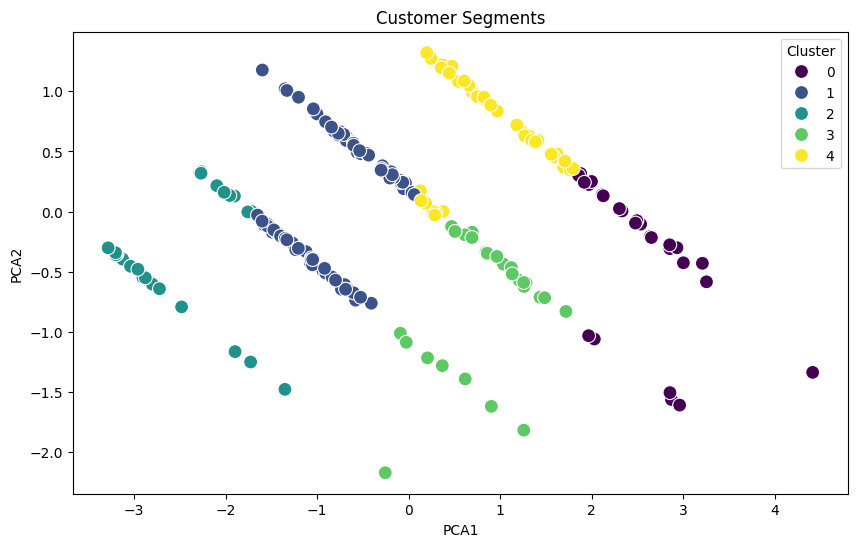

In [23]:


# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Add PCA components to the customer_agg dataframe
customer_agg['PCA1'] = pca_components[:, 0]
customer_agg['PCA2'] = pca_components[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_agg, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segments')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', loc='best')
plt.show()


In [26]:
# Save the resulting dataframe with cluster assignments
customer_agg.to_csv('/content/drive/MyDrive/Colab Notebooks/segmented_customers.csv', index=False)
